In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import PathPatch
from matplotlib.lines import Line2D
from statsmodels.stats.multitest import multipletests
import sys 

def fdr_and_bonf_labels(
    pvals_raw: pd.Series,
    rois: list[str] | None = None,
    m_tests: int | None = None,
    fdr05: float = 0.05,
    fdr001: float = 0.001,
    fwer_alpha: float = 0.05,
    p_distribution5: float = 0.05,
):
    """
    Returns:
      q_fdr: Series of BH-FDR q-values
      bonf_thr: float
      badges: DataFrame with boolean columns:
        - fdr05:  p < 0.05
        - bonf:   p <= bonf_thr
        - fdr001: q < 0.001
        - p_distribution5: p<=0.05 uncorrected 
    """
    p = pvals_raw.astype(float).copy()
    if rois is not None:
        p = p.reindex(rois)

    valid = p.notna() & np.isfinite(p.to_numpy())
    q = pd.Series(np.nan, index=p.index, dtype=float)

    if valid.any():
        pv = p[valid].to_numpy()
        _, qv, _, _ = multipletests(pv, method="fdr_bh")
        q.loc[p[valid].index] = qv

    if m_tests is None:
        m_tests = int(valid.sum())
    bonf_thr = fwer_alpha / m_tests

    badges = pd.DataFrame(index=p.index)
    badges["p05_unc"] = (p < p_distribution5)
    badges["fdr05"] = (q < fdr05)
    badges["bonf"] = (p <= bonf_thr)
    badges["fdr001"] = (q < fdr001)

    return q, bonf_thr, badges


def distribution(
    df, cols_to_plot, var_to_plot,
    grouping=None, xlabel=None, ylabel=None, save_path=None,
    pvals: pd.Series | None = None,
    p_colors=None,  # yellow, dark green, light green
    sig_show=("unc05", "fdr05", "bonf", "fdr001"), 
):
    """Plot boxplots + stripplot. Optionally add stacked significance connector lines per ROI
    using a Series of (FDR-corrected) p-values indexed by ROI name.

    Parameters
    ----------
    pvals : pd.Series | None
        Series indexed by ROI name (matching entries of cols_to_plot), values are p-values.
        Example:
            superiorfrontal 0.013
            caudalmiddlefrontal 0.0071
            ...
    p_colors : tuple
        Colors for the three stacked lines in the same order.
    """

    font_size = 18
    if isinstance(sig_show, str):
        sig_show = (sig_show,)
    else:
        sig_show = tuple(sig_show)
    show_unc05 = (grouping is not None) and ("GROUP" in str(grouping))

    if grouping:
        if "Phenotype" in grouping:
            df_long = df[cols_to_plot + ['Subj_ID', grouping, 'Time']].melt(
                id_vars=['Subj_ID', grouping, 'Time'],
                var_name=var_to_plot,
                value_name='Value'
            )
            order_group = {'C','P'}
        else:
            df_long = df[cols_to_plot + ['Subj_ID', grouping]].melt(
                id_vars=['Subj_ID', grouping],
                var_name=var_to_plot,
                value_name='Value'
            )
            if "GROUP" in grouping:
                # for ordering the plot of the groups 
                order_group = ['HC','MSA']
            elif "Time" in grouping:
                order_group = ['BL','FUP']
            

        # Define palette
        if 'Time' in grouping:
            palette = {'BL': '#0072B2', 'FUP': '#E69F00'}
        elif 'MCI' in grouping:
            palette = {'MCI_NO': '#56B4E9', 'MCI_YES': '#D55E00'}
        elif 'Phenotype' in grouping:
            palette = {'C': '#6A3D9A', 'P': '#1B9E77'}
        elif 'GROUP' in grouping:
            palette = {'HC': '#8DA0CB', 'MSA': '#FC8D62'}
        else:
            palette = 'Set2'
    else:
        df_long = df[cols_to_plot + ['Subj_ID']].melt(
            id_vars='Subj_ID',
            var_name=var_to_plot,
            value_name='Value'
        )
        palette = 'Set2'

    plt.figure(figsize=(15, 10))
    plt.xticks(rotation=45, ha='right')

    # ---- add visual gaps between ROI categories ----
    gap_every = True
    order_with_gaps = []
    gap_labels = []  # store the gap category names so we can draw separators

    for i, roi in enumerate(cols_to_plot):
        order_with_gaps.append(roi)
        if i < len(cols_to_plot) - 1 and gap_every:
            g = f"__gap_{i}__"
            order_with_gaps.append(g)
            gap_labels.append(g)

    # Force categorical order (keeps gaps even if they have no data)
    df_long[var_to_plot] = pd.Categorical(df_long[var_to_plot],
                                      categories=order_with_gaps,
                                      ordered=True)

    if grouping:
        ax = sns.boxplot(
            x=var_to_plot, y='Value', hue=grouping, data=df_long, hue_order=order_group,
            palette=palette, dodge=True, width=1.5, linewidth=2, fliersize=0, zorder=1,order=order_with_gaps)
    else:
        ax = sns.boxplot(
            x=var_to_plot, y='Value', hue=var_to_plot, data=df_long,
            palette=palette, dodge=True, width=1.5, linewidth=2, fliersize=0, zorder=1,order=order_with_gaps
        )

    # Make boxplots unfilled
    for artist in ax.artists:
        artist.set_facecolor('none')
        artist.set_edgecolor('black')
        artist.set_linewidth(1.2)

    if grouping and ("Phenotype" in grouping):
        sns.stripplot(
            x=var_to_plot, y='Value', hue=grouping,hue_order=order_group,
            data=df_long[df_long['Time'] == 'BL'],
            dodge=True, jitter=True, marker='D',
            palette=palette, linewidth=0.8, alpha=0.5, edgecolor='auto', zorder=2,order=order_with_gaps, size=3)
        sns.stripplot(
            x=var_to_plot, y='Value', hue=grouping,hue_order=order_group,
            data=df_long[df_long['Time'] == 'FUP'],
            dodge=True, jitter=True, marker='s',
            palette=palette, linewidth=0.8, alpha=0.5, edgecolor='auto', zorder=2,order=order_with_gaps, size=3)
    else:
        sns.stripplot(
            x=var_to_plot, y='Value', hue=grouping, data=df_long,hue_order=order_group,
            dodge=True if grouping else 0, jitter=True,
            palette=palette, linewidth=0.8, alpha=0.8, edgecolor='auto', zorder=2,order=order_with_gaps, size=3)
        

    # ---- clean x tick labels: hide gap labels ----
    ticklabels = []
    for lab in ax.get_xticklabels():
        t = lab.get_text()
        ticklabels.append("" if t.startswith("__gap_") else t)
    ax.set_xticklabels(ticklabels, rotation=90, ha='right')

    # ---- add thin dotted vertical lines in the gaps ----
    ymin, ymax = ax.get_ylim()
    for j, cat in enumerate(order_with_gaps):
        if isinstance(cat, str) and cat.startswith("__gap_"):
            ax.axvline(j, ymin=0, ymax=1, linestyle=":", linewidth=2, alpha=0.75, zorder=0)

    # Keep the vlines spanning correctly if limits change later
    ax.set_ylim(ymin, ymax)

    if grouping == "Time":
        # Make sure hue order is stable (BL left, FUP right)
        hue_order = ["BL", "FUP"]  # adjust if your labels differ
        roi_names = cols_to_plot

        # Collect box patches (2 per ROI)
        box_patches = [p for p in ax.patches if isinstance(p, PathPatch)]
        xticks = ax.get_xticks()

        def patch_center_x(patch):
            bb = patch.get_extents().transformed(ax.transData.inverted())
            return 0.5 * (bb.x0 + bb.x1)

        # Assign patches to nearest tick index (category position in order_with_gaps)
        patches_by_tick = {i: [] for i in range(len(xticks))}
        for p in box_patches:
            x = patch_center_x(p)
            ti = int(np.argmin(np.abs(xticks - x)))
            patches_by_tick[ti].append((x, p))

        # Compute means per Time for each ROI and draw line between box centers
        for roi in roi_names:
            if roi not in order_with_gaps:
                continue
            ti = order_with_gaps.index(roi)

            bucket = patches_by_tick.get(ti, [])
            if len(bucket) < 2:
                continue

            # left and right box centers for this ROI (aligned to seaborn dodge)
            bucket_sorted = sorted(bucket, key=lambda t: t[0])
            x_left = bucket_sorted[0][0]
            x_right = bucket_sorted[-1][0]

            temp = df[[roi, grouping]].dropna()
            mean_values = temp.groupby(grouping)[roi].mean()

            # ensure both expected levels exist
            if not all(h in mean_values.index for h in hue_order):
                continue

            y_left = float(mean_values.loc[hue_order[0]])
            y_right = float(mean_values.loc[hue_order[1]])

            ax.plot([x_left, x_right], [y_left, y_right],
                    color="black", linewidth=2.5, zorder=15)

    def add_sig_connectors_bottom(ax, rois, sig_labels, order_with_gaps, p_colors=None, sig_show = sig_show):
        """
        Draw stacked bottom connector lines per ROI based on a BITMASK integer:
        1:  uncorrected p < 0.05
        2:  BH-FDR p < 0.05
        4:  Bonferroni p <= thr
        8:  BH-FDR q < 0.001
        """

        if sig_labels is None or grouping is None:
            return

        hue_levels = list(pd.unique(df_long[grouping].dropna()))
        if len(hue_levels) != 2:
            return

        box_patches = [p for p in ax.patches if isinstance(p, PathPatch)]
        if len(box_patches) == 0:
            return
        
        xticks = ax.get_xticks()
        patches_by_tick = {i: [] for i in range(len(xticks))}

        def patch_center(patch):
            bb = patch.get_extents().transformed(ax.transData.inverted())
            return 0.5 * (bb.x0 + bb.x1)

        for p in box_patches:
            x = patch_center(p)
            ti = int(np.argmin(np.abs(xticks - x)))
            patches_by_tick[ti].append((x, p))

        y_min, y_max = ax.get_ylim()
        yr = (y_max - y_min) if (y_max > y_min) else 1.0

        bottom_pad = 0.12 * yr
        ax.set_ylim(y_min - bottom_pad, y_max)

        y_min2, y_max2 = ax.get_ylim()
        yr2 = y_max2 - y_min2
        y_sig = y_min2 + 0.06 * yr2

        v_gap = 0.02 * yr2
        neutral_color = "#333333"

        # ---- choose style map depending on whether colors are provided ----
        use_colors = (p_colors is not None)

        if use_colors:
            assert len(p_colors) >= 4, "p_colors must have 4 colors: (unc05, fdr05, bonf, fdr001)"
            STYLE = {
                1: dict(color=p_colors[0], lw=3.0, ls="-"),  # uncorrected p<0.05
                2: dict(color=p_colors[1], lw=3.0, ls="-"),  # FDR<0.05
                4: dict(color=p_colors[2], lw=3.0, ls="-"),  # Bonf
                8: dict(color=p_colors[3], lw=3.0, ls="-"),  # FDR<0.001
            }
        else:
            # paper-safe: one color, line style/width encodes meaning
            STYLE = {
                1: dict(color=neutral_color, lw=1.5, ls=":"),   # uncorrected p<0.05
                2: dict(color=neutral_color, lw=2.5, ls=":"),  # FDR<0.05
                4: dict(color=neutral_color, lw=2.5, ls="-"),   # Bonf
                8: dict(color=neutral_color, lw=3.5, ls="-"),   # FDR<0.001
            }

        bit_order = [1, 2, 4, 8]
        # tod efine which horizontal lines to show 
        SHOWMAP = {"unc05": 1, "fdr05": 2, "bonf": 4, "fdr001": 8}
        sig_show = tuple(sig_show) if isinstance(sig_show, (list, tuple, set)) else (sig_show,)
        allowed_bits = [SHOWMAP[k] for k in ("unc05", "fdr05", "bonf", "fdr001") if k in sig_show]
        bit_order = allowed_bits 
        allowed_mask = 0
        for b in allowed_bits:
            allowed_mask |= b

        for roi in rois:
            lab = sig_labels.get(roi, 0)
            if pd.isna(lab):
                continue
            lab = int(lab)
            
            if not show_unc05: # drop p < 0.05 uncorrected when comparing long data over phenotype or time 
                lab = lab & ~1   

            lab = lab & allowed_mask # this is to handle the showing lines
            print(roi, "lab(after mask)=", lab, "allowed_mask=", allowed_mask, "bit_order=", bit_order)
            if lab == 0 or roi not in order_with_gaps:
                continue

            ti = order_with_gaps.index(roi)
            bucket = patches_by_tick.get(ti, [])
            if len(bucket) < 2:
                continue

            bucket_sorted = sorted(bucket, key=lambda t: t[0])
            x0 = bucket_sorted[0][0]
            x1 = bucket_sorted[-1][0]

            span = x1 - x0
            base_shrink = 0.03 * span
            extra_shrink = 0.02 * span

            # which bits are present?
            active_bits = [b for b in bit_order if (lab & b)]
            if not active_bits:
                continue

            for k, bit in enumerate(active_bits):
                s = base_shrink + k * extra_shrink
                yk = y_sig + k * v_gap
                st = STYLE[bit]
                ax.plot(
                    [x0 + s, x1 - s],
                    [yk, yk],
                    zorder=300,
                    clip_on=False,
                    solid_capstyle="round",
                    **st,
                )
          
    if pvals is not None:     
        add_sig_connectors_bottom(ax, cols_to_plot, pvals, order_with_gaps, p_colors=p_colors, sig_show=sig_show)

        # ---- Fix legend (your existing logic, but guard grouping=None) ----
        handles, labels = ax.get_legend_handles_labels()
        SHOW = set(sig_show)
        if p_colors is None:
            sig_handles = []
            if "unc05" in SHOW and show_unc05:
                sig_handles.append(Line2D([0],[0], color="#333333", ls=":", lw=1.5, label="p < 0.05 (uncorrected)"))
            if "fdr05" in SHOW:
                sig_handles.append(Line2D([0],[0], color="#333333", ls=":", lw=2.5, label="p < 0.05 (FDR-BH)"))
            if "bonf" in SHOW:
                sig_handles.append(Line2D([0],[0], color="#333333", ls="-",  lw=2.5, label=f"p < 0.05/{len(cols_to_plot)} (Bonferroni)"))
            if "fdr001" in SHOW:
                sig_handles.append(Line2D([0],[0], color="#333333", ls="-",  lw=3.5, label="q < 0.001 (FDR-BH)"))
        else:
            sig_handles = []
            if "unc05" in SHOW and show_unc05:
                sig_handles.append(Line2D([0],[0], color=p_colors[0], lw=3, label="p < 0.05 (uncorrected)"))
            if "fdr05" in SHOW:
                sig_handles.append(Line2D([0],[0], color=p_colors[1], lw=3, label="p < 0.05 (FDR-BH)"))
            if "bonf" in SHOW:
                sig_handles.append(Line2D([0],[0], color=p_colors[2], lw=3, label=f"p < 0.05/{len(cols_to_plot)} (Bonferroni)"))
            if "fdr001" in SHOW:
                sig_handles.append(Line2D([0],[0], color=p_colors[3], lw=3, label="q < 0.001 (FDR-BH)"))


            
        if grouping:
            uniq = list(pd.unique(df[grouping].dropna()))
            base_handles = handles[:len(uniq)]
            base_labels  = labels[:len(uniq)]
        else:
            base_handles = handles
            base_labels  = labels

        legend = ax.legend(base_handles + sig_handles,
            base_labels + [h.get_label() for h in sig_handles],
            title=None,
            fontsize=font_size,
            loc="upper left",
            #bbox_to_anchor=(0.01, 0.01),
            frameon=False)
    else: 
        handles, labels = ax.get_legend_handles_labels()
        base_handles = handles[0:2]
        base_labels  = labels[0:2]
        legend = ax.legend(
            base_handles ,
            base_labels ,
            title=None,
            fontsize=font_size,
            loc="upper left",
            #bbox_to_anchor=(0.01, 0.01),
            frameon=False,
        )

    sns.despine()

    # ---- remove ticks for gap categories entirely ----
    xticks = ax.get_xticks()
    xticklabels = ax.get_xticklabels()

    new_ticks = []
    new_labels = []

    for tick, lab in zip(xticks, xticklabels):
        region_name = lab.get_text()  # This gives 'superiorparietal', etc.
        if region_name != '':  # the line are empty so remove them
            new_ticks.append(tick)
            new_labels.append(lab.get_text())

    ax.set_xticks(new_ticks)
    ax.set_xticklabels(new_labels, rotation=45, ha="right")
    for labelx in ax.get_xticklabels():
        labelx.set_fontweight("bold")
        
    for labely in ax.get_yticklabels():
        labely.set_fontweight("bold")
    #ax.set_xlabel(var_to_plot, fontweight="bold")
    ax.set_xlabel(None)
    ax.set_ylabel(ylabel, fontsize = font_size, fontweight="bold")
    plt.xticks(fontsize=font_size, fontweight='bold')
    plt.yticks(fontsize=font_size, fontweight='bold')
    ax.margins(x=0)
    ax.set_xlim(-1, len(order_with_gaps) )
    if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Figure saved to {save_path}")

    plt.show()

def plot_horizontal_bars(
    df,
    value_col="Value",
    xlabel="Value",
    title=None,
    figsize=(6, 4),
    color="#6E6E6E",
    edgecolor="black",
    label_fmt="{:.3f}",
    save_path=None,
):
    """
    Plot a clean horizontal bar plot from a sorted DataFrame.

    Parameters
    ----------
    df : pandas.DataFrame
        Index = ROI names, column = numeric values.
        Should already be sorted in the desired order.
    value_col : str
        Name of the numeric column to plot.
    xlabel : str
        Label for the x-axis.
    title : str or None
        Optional title.
    figsize : tuple
        Figure size in inches.
    color : str
        Bar fill color (grayscale recommended).
    edgecolor : str
        Bar edge color.
    label_fmt : str
        Format string for value labels (e.g. "{:.3f}").
    save_path : str or None
        If provided, saves the figure to this path.
    """
    font_size = 7
    # ---- basic checks ----
    if value_col not in df.columns:
        raise ValueError(f"Column '{value_col}' not found in DataFrame")

    values = df[value_col].to_numpy()
    labels = df.index.astype(str)

    
    fig, ax = plt.subplots(figsize=figsize)

    y = np.arange(len(df))
    ax.barh(
        y,
        values,
        height=0.5,        
        color=color,
        edgecolor=edgecolor,
    )

    ax.set_yticks(y)
    ax.set_yticklabels(labels)
    ax.tick_params(axis="y", labelsize=font_size) 
    for label in ax.get_yticklabels():
        label.set_fontweight("bold")
    # remove x-axis completely
    ax.get_xaxis().set_visible(False)
    ax.set_ylabel("")

    if title is not None:
        ax.set_title(
            title,
            fontsize=font_size,
            fontweight="bold",
            pad=2   # vertical distance above the axes (in points)
        )

    # ---- value labels ----
    xlim = ax.get_xlim()
    x_offset = 0.01 * (xlim[1] - xlim[0])

    for i, v in enumerate(values):
        ax.text(
            v + x_offset,
            i,
            label_fmt.format(v),
            va="center",
            fontsize=font_size,
        )

    # ---- styling ----
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)  # explicit, belt & suspenders
    ax.grid(False)
    ax.margins(x=0.15)

    plt.tight_layout()

    if save_path is not None: 
        plt.savefig(save_path, dpi=300, bbox_inches="tight") 
    plt.show()


In [ ]:
# control variables
doCT = True  # mutually exlusive with doVOL
doVOL = False
atlas_name = 'DKT' # DKT or Schaefer
remove_out = True #
cross_analysis = 0 # mutually exlusive with long_analysis
long_analysis = 1

if remove_out == 1 and long_analysis == 1:  # outlier removal only for the long analysis 
    suffix = '_data_clean_outlier_removed' 
elif remove_out == 0:
    suffix = ''

if doCT == 1:
    if atlas_name == 'Schaefer':
        NPARC = 400
        NNET = 17
    elif atlas_name == 'DKT':
        NPARC = False 
        NNET = False 

if doVOL == True and doCT == False and long_analysis == True and cross_analysis == False:
    save_path = f"/home/riccardo/codici_progetti/MSA_paper/MSA_long_paper/figures/VOL_LONG"
elif doVOL == True and doCT == False and long_analysis == False and cross_analysis == True:
    save_path = f"/home/riccardo/codici_progetti/MSA_paper/MSA_long_paper/figures/VOL_CROSS"
elif doVOL == False and doCT == True and long_analysis == True and cross_analysis == False:
    save_path = f"/home/riccardo/codici_progetti/MSA_paper/MSA_long_paper/figures/CT_LONG"
elif doVOL == False and doCT == True and long_analysis == False and cross_analysis == True:
    save_path = f"/home/riccardo/codici_progetti/MSA_paper/MSA_long_paper/figures/CT_CROSS"
else:
    print("input varibales are wrong")
    sys.exit()
input_path = f"/home/riccardo/codici_progetti/MSA_paper/MSA_long_paper/matrices"

if doCT == 1 and doVOL == 0:
    if cross_analysis == 1 and long_analysis == 0:
        if atlas_name == 'DKT':
            data = pd.read_csv(f"{input_path}/CT_cross_HC_vs_crossMSA.csv") # do not use here crossMSAALL 
            data_model =  pd.read_csv(f"{input_path}/CT_recap_HC_vs_crossMSA.csv")
            roi_names = ['superiorfrontal', 'caudalmiddlefrontal','rostralmiddlefrontal', 'parstriangularis', 'parsopercularis', 'parsorbitalis','lateralorbitofrontal', 'medialorbitofrontal', 'precentral', \
                     'paracentral',  'superiorparietal', 'inferiorparietal', 'supramarginal', 'postcentral', 'precuneus', 'superiortemporal', 'middletemporal', 'inferiortemporal', 'fusiform', 'transversetemporal', \
                    'parahippocampal', 'entorhinal',  'lateraloccipital', 'lingual',  'cuneus', 'pericalcarine','rostralanteriorcingulate','caudalanteriorcingulate', 'posteriorcingulate','isthmuscingulate','insula']

            # loading fsquares as calculated with R 
            effect_sizes = pd.read_csv(f"{input_path}/fsquare_ancova_CT.csv")
            effect_sizes = effect_sizes.set_index("ROI")
        
        elif atlas_name == 'Schaefer':
            data = pd.read_csv(f"{input_path}/CT_cross_HC_vscrossMSA_Schaefer_Parc{NPARC}_NET{NNET}.csv") # do not use here crossMSAALL 
            data_model =  pd.read_csv(f"{input_path}/CT_recap_HC_vscrossMSA_Schaefer_Parc{NPARC}_NET{NNET}.csv")
            if NNET == 17: 
                roi_names = ['VisCent','VisPeri','SomMotA','SomMotB','DorsAttnA','DorsAttnB','SalVentAttnA','SalVentAttnB','LimbicA','LimbicB','ContA','ContB','ContC','DefaultA','DefaultB','DefaultC','TempPar']
            elif NNET == 7:
                roi_names = ['Vis','SomMot','DorsAttn','SalVentAttn','Limbic','Cont','Default']

            # loading fsquares as calculated with R 
            effect_sizes = pd.read_csv(f"{input_path}/fsquare_ancova_CT_{atlas_name}_{NPARC}_{NNET}.csv")
            effect_sizes = effect_sizes.set_index("ROI")
        
    elif cross_analysis == 0 and long_analysis == 1:  # for the long analysis you have also the outlier yes or not included option 
        if atlas_name == 'DKT':
            data = pd.read_csv(f"{input_path}/CT_MSAlong{suffix}.csv")
            data_model =  pd.read_csv(f"{input_path}/CT_recap_MSAlong{suffix}.csv")
            # loading fsquares as calculated with R 
            effect_sizes = pd.read_csv(f"{input_path}/fsquare_MSAlong_CT.csv")
            effect_sizes = effect_sizes.set_index("ROI")

            roi_names = ['superiorfrontal', 'caudalmiddlefrontal','rostralmiddlefrontal', 'parstriangularis', 'parsopercularis', 'parsorbitalis','lateralorbitofrontal', 'medialorbitofrontal', 'precentral', \
                     'paracentral',  'superiorparietal', 'inferiorparietal', 'supramarginal', 'postcentral', 'precuneus', 'superiortemporal', 'middletemporal', 'inferiortemporal', 'fusiform', 'transversetemporal', \
                    'parahippocampal', 'entorhinal',  'lateraloccipital', 'lingual',  'cuneus', 'pericalcarine','rostralanteriorcingulate','caudalanteriorcingulate', 'posteriorcingulate','isthmuscingulate','insula']
        elif atlas_name == 'Schaefer':
            data = pd.read_csv(f"{input_path}/CT_MSAlong_Schaefer_Parc{NPARC}_NET{NNET}{suffix}.csv")
            data_model =  pd.read_csv(f"{input_path}/CT_recap_MSAlong_Schaefer_Parc{NPARC}_NET{NNET}{suffix}.csv")

            # loading fsquares as calculated with R 
            effect_sizes = pd.read_csv(f"{input_path}/fsquare_MSAlong_CT_Schaefer_Parc{NPARC}_NET{NNET}.csv")
            effect_sizes = effect_sizes.set_index("ROI")

            # handle only the case within the network. NOT DIVIDED between left and right 
            if NNET == 17: 
                roi_names = ['VisCent','VisPeri','SomMotA','SomMotB','DorsAttnA','DorsAttnB','SalVentAttnA','SalVentAttnB','LimbicA','LimbicB','ContA','ContB','ContC','DefaultA','DefaultB','DefaultC','TempPar']
            elif NNET == 7:
                roi_names = ['Vis','SomMot','DorsAttn','SalVentAttn','Limbic','Cont','Default']
 
    varname = 'CT'
    
    ylab = 'CT [mm]'
    if NPARC != 0:  # handling Schaefer atlas saving
        if cross_analysis == 0 and long_analysis == 1:
            save_figure = f"{save_path}/CT_{atlas_name}_{NPARC}_{NNET}{suffix}"
            save_effect_figure = f"{save_path}/CT_effect_sizes_LONGLME_{atlas_name}_{NPARC}_{NNET}{suffix}"
        elif cross_analysis == 1 and long_analysis == 0:
            save_figure = f"{save_path}/CT_{atlas_name}_{NPARC}_{NNET}"
            save_effect_figure = f"{save_path}/CT_effect_sizes_CROSSANCOVA_{atlas_name}_{NPARC}_{NNET}"
    elif NPARC == False:  # handling DK atlas saving 
        if cross_analysis == 0 and long_analysis == 1:
            save_figure = f"{save_path}/CT_{atlas_name}{suffix}"
            save_effect_figure = f"{save_path}/CT_effect_sizes_LONGLME_{atlas_name}{suffix}"
        elif cross_analysis == 1 and long_analysis == 0:
            save_figure = f"{save_path}/CT_effect_sizes_{atlas_name}"
            save_effect_figure = f"{save_path}/CT_effect_sizes_CROSSANCOVA_{atlas_name}"


elif doCT == 0 and doVOL == 1:
    if cross_analysis == 1 and long_analysis == 0:
        data = pd.read_csv(f"{input_path}/VOL_cross_HC_vs_crossMSA.csv")
        data_model =  pd.read_csv(f"{input_path}/VOL_recap_HC_vs_crossMSA.csv")
        effect_sizes = pd.read_csv(f"{input_path}/fsquare_ancova_VOL.csv")
        effect_sizes = effect_sizes.set_index("ROI")
        
        save_figure = f"{save_path}/VOL_"
        save_effect_figure = f"{save_path}/VOL_effect_sizes_CROSSANCOVA"
    elif cross_analysis == 0 and long_analysis == 1:
        data = pd.read_csv(f"{input_path}/VOL_MSAlong{suffix}.csv")
        data_model =  pd.read_csv(f"{input_path}/VOL_recap_MSAlong{suffix}.csv")
        # loading fsquares as calculated with R 
        #effect_sizes = pd.read_csv(f"{input_path}/fsquare_MSAlong_VOL{suffix}.csv")
        #effect_sizes = effect_sizes.set_index("ROI")
        
        # only for the volumetric analysis over time, effect of the phenotype 
        #effect_sizes_pheno = pd.read_csv(f"{input_path}/fsquare_MSAlong_VOL_Phenotype{suffix}.csv")
        #effect_sizes_pheno = effect_sizes_pheno.set_index("ROI")
        
        save_figure = f"{save_path}/VOL_{suffix}"
        save_effect_figure = f"{save_path}/VOL_effect_sizes_LONGLME{suffix}"
        save_effect_figure_pheno = f"{save_path}/VOL_effect_sizes_LONGLME_Phenotype{suffix}"

    data.rename(columns = {'CerebellumWhiteMatter':'WM','CerebellumCortex':'GM'} , inplace=True )
    roi_names = [ 'Putamen', 'WM', 'GM', 'Pons']

    data_model.columns = data_model.columns.str.replace("CerebellumWhiteMatter", "WM", regex=False)
    data_model.columns = data_model.columns.str.replace("CerebellumCortex", "GM", regex=False)
    #effect_sizes.index = effect_sizes.index.str.replace("CerebellumWhiteMatter","WM", regex=False)
    #effect_sizes.index = effect_sizes.index.str.replace("CerebellumCortex","GM", regex=False)
    #effect_sizes_pheno.index = effect_sizes_pheno.index.str.replace("CerebellumCortex","GM", regex=False)
    #effect_sizes_pheno.index = effect_sizes_pheno.index.str.replace("CerebellumWhiteMatter","WM", regex=False)
    varname = 'VOL'
    
    ylab =  'VOL NORM ICV [%]'

data.rename(columns={"Subject": "Subj_ID"}, inplace = True)

#print(data['Subj_ID'])
#print(data_model)
if cross_analysis == 1 and long_analysis == 0:

    row = data_model.loc[data_model["Labels"] == "GROUP_MSA"]
    pvals_cols = [c for c in data_model.columns  if (c not in ["Labels"] and "_estimate" not in c and "_eta" not in c)]
    pvals = row[pvals_cols].squeeze()
    eta_cols = [c for c in data_model.columns if "_eta" in c]
    eta = row[eta_cols].squeeze()

elif cross_analysis == 0 and long_analysis == 1:

    #pvals = data_model.iloc[5, 2::5]
    row = data_model.loc[data_model["Labels"] == "Time_T1"]
    pvals_cols = [c for c in data_model.columns if (c not in ["Labels"] and "_estimate" not in c and "_eta" not in c)]
    pvals = row[pvals_cols].squeeze()
    eta_cols_time = [c for c in data_model.columns if "_eta_Time" in c]
    eta_time = row[eta_cols_time].squeeze()
    
    
    row_phenotype = data_model.loc[data_model["Labels"] == "SottotipoMotorio_P"]
    pvals_phenotype_cols = [ c for c in data_model.columns   if (c not in ["Labels"] and "_estimate" not in c and "_eta" not in c)]
    pvals_phenotype = row_phenotype[pvals_phenotype_cols].squeeze()
    eta_cols_phenotype = [c for c in data_model.columns if "_eta_Phenotype" in c]
    eta_phenotype = row[eta_cols_phenotype].squeeze()
    

         p05_unc  fdr05  bonf  fdr001
Putamen     True   True  True    True
WM          True   True  True    True
GM          True   True  True    True
Pons        True   True  True    True
15    4
Name: count, dtype: int64
ROIs with FDR<0.001: 4
Putamen    15
WM         15
GM         15
Pons       15
dtype: int64
          WM        GM  Thalamus   Caudate   Putamen  Pallidum  brain_stem  \
0   2.222548  6.187316  0.941426  0.447453  0.572328  0.197622    2.553744   
1   1.845638  5.578004  0.909722  0.496520  0.601825  0.192443    2.151299   
2   1.456405  5.653546  0.843243  0.516177  0.559202  0.190030    2.051165   
3   2.028923  6.134207  0.914723  0.424326  0.419950  0.156882    2.730837   
4   2.361775  6.956382  0.949758  0.519406  0.475643  0.149014    2.885006   
..       ...       ...       ...       ...       ...       ...         ...   
67  1.633899  5.897548  0.870444  0.521562  0.613088  0.206412    1.876923   
68  1.616706  5.443975  0.810882  0.442395  0.513699  0.1716

/tmp/ipykernel_9408/3187125435.py:182: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ticklabels, rotation=90, ha='right')


Figure saved to /home/riccardo/codici_progetti/MSA_paper/MSA_long_paper/figures/VOL_LONG/VOL__data_clean_outlier_removed_MSAlong_time.png


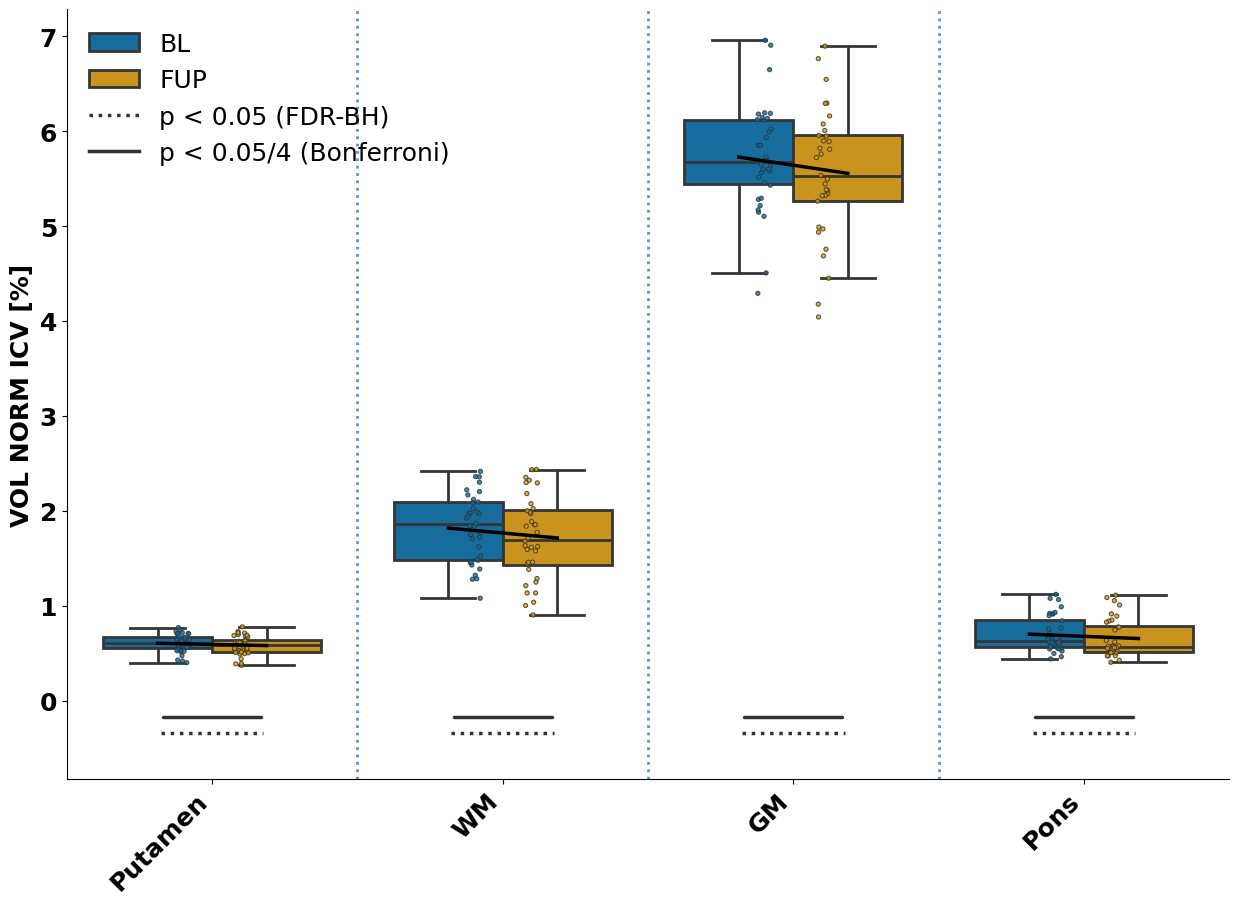

these are the values of the TIME eta effect sizes for p < 0.05 FDR
Putamen    True
WM         True
GM         True
Pons       True
dtype: bool
Putamen_eta_Time    0.369322
WM_eta_Time         0.228479
GM_eta_Time         0.208750
Pons_eta_Time       0.529213
Name: 5, dtype: float64
Putamen_eta_Time    0.369322
WM_eta_Time         0.228479
GM_eta_Time         0.208750
Pons_eta_Time       0.529213
Name: 5, dtype: float64
Putamen    0
WM         0
GM         0
Pons       0
dtype: int64
         p05_unc  fdr05   bonf  fdr001
Putamen     True   True   True    True
WM          True   True  False   False
GM         False  False  False   False
Pons        True   True   True   False
Putamen lab(after mask)= 6 allowed_mask= 6 bit_order= [2, 4]
WM lab(after mask)= 2 allowed_mask= 6 bit_order= [2, 4]
GM lab(after mask)= 0 allowed_mask= 6 bit_order= [2, 4]
Pons lab(after mask)= 6 allowed_mask= 6 bit_order= [2, 4]


/tmp/ipykernel_9408/3187125435.py:182: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ticklabels, rotation=90, ha='right')


Figure saved to /home/riccardo/codici_progetti/MSA_paper/MSA_long_paper/figures/VOL_LONG/VOL__data_clean_outlier_removed_HC_vs_MSA_Phenotype.png


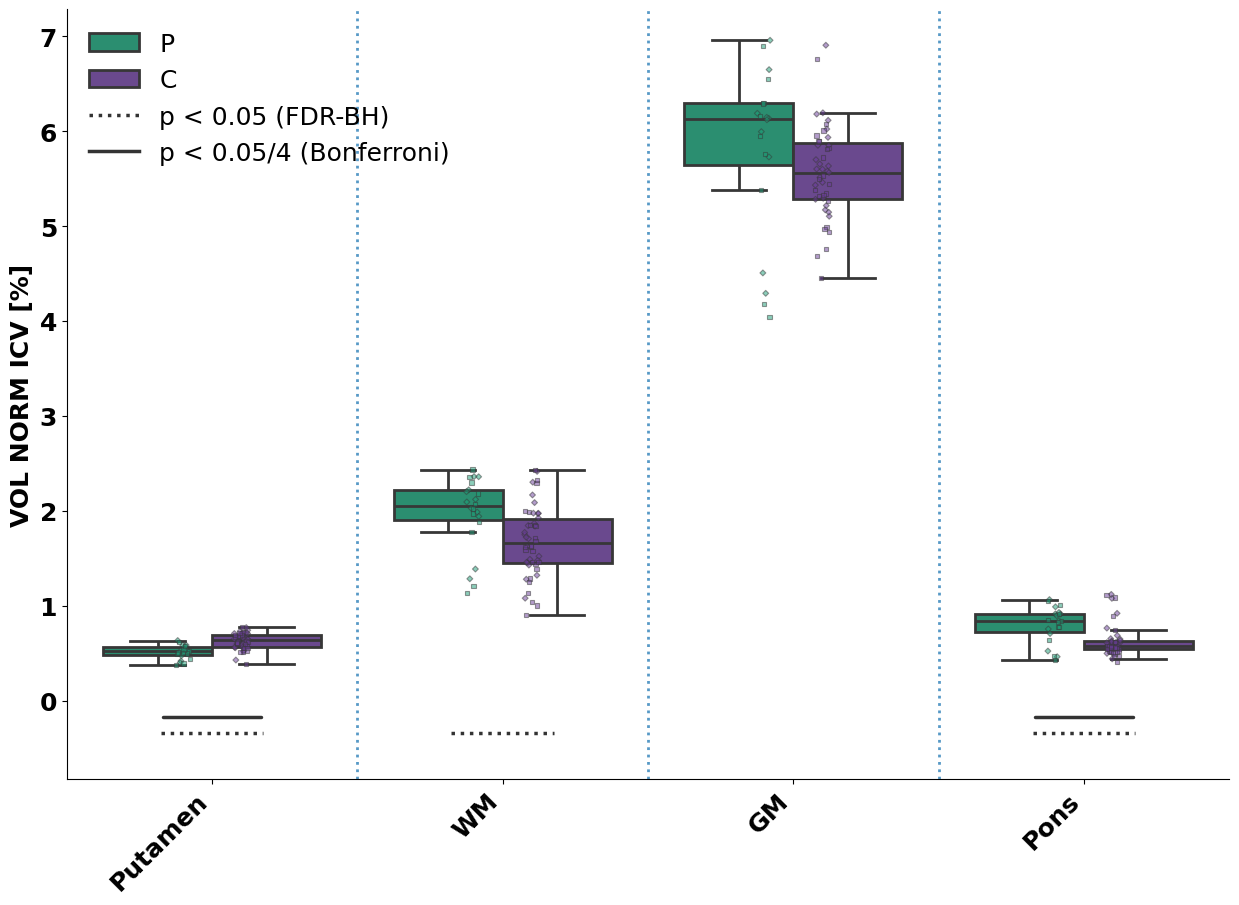

these are the values of the PHENOTYPE eta effect sizes for p < 0.05 FDR
Putamen_eta_Phenotype    0.224378
WM_eta_Phenotype         0.065807
Pons_eta_Phenotype       0.104667
Name: 5, dtype: float64


In [8]:
#print(roi_names[:8])
#print(list(pvals.index)[:8])
#print("Overlap:", len(set(roi_names) & set(pvals.index)))

if doVOL == 1 and doCT ==0:
    number_roi = 4
if doVOL == 0 and doCT ==1:
    if atlas_name == 'DKT':
        number_roi = 31
    elif atlas_name == 'Schaefer':
        number_roi = NNET
        
q_fdr , bonf_thr , sig_labels = fdr_and_bonf_labels(pvals_raw = pvals, rois = roi_names, m_tests = number_roi, fdr05 = 0.05, fdr001 = 0.001, fwer_alpha = 0.05)
print(sig_labels)
#print(sig_labels.sum(axis=1))
# example bitmask creation
sig = pd.Series(0, index=roi_names, dtype=int)
# coding Value	Binary	Meaning
#000	nothing
#	001	FDR<0.05
#	010	Bonf only
#	011	FDR<0.05 + Bonf
#	100	FDR<0.001 only
#	101	FDR<0.05 + FDR<0.001
#	110	Bonf + FDR<0.001
#	111	all three
# just plot in distribtuion if you have one, two or three 
# bit 0: uncorrected p < 0.05
sig.loc[sig_labels["p05_unc"]] |= 1
# bit 1: FDR < 0.05
sig.loc[sig_labels["fdr05"]] |= 2
# bit 2: Bonferroni
sig.loc[sig_labels["bonf"]] |= 4
# bit 3: FDR < 0.001
sig.loc[sig_labels["fdr001"]] |= 8

print(sig.value_counts().sort_index())
print("ROIs with FDR<0.001:", (sig & 8).astype(bool).sum())

if long_analysis == 0 and cross_analysis == 1:
    if doVOL == True and doCT == False:
        distribution(data,roi_names, varname, 'GROUP', 'ROI', ylab,  f"{save_figure}_HC_vs_MSA.png", sig, p_colors=None, sig_show = ("fdr05", "bonf")) # p_colors=("#FFD343","#7FC97F", "#1B9E77", "#00441B"))
    elif doCT == True and doVOL == False: 
        distribution(data,roi_names, varname, 'GROUP', 'ROI', ylab,  f"{save_figure}_HC_vs_MSA.png", sig, p_colors=None, sig_show = ("unc05")) # p_colors=("#FFD343","#7FC97F", "#1B9E77", "#00441B"))

    # print eta for effect size - GROUP
    print("these are the values of the GROUP eta effect sizes for p < 0.05 FDR")
    sig_areas_index = sig_labels.any(axis=1)
    print(eta[sig_areas_index.values])

elif long_analysis == 1 and cross_analysis == 0:
    
    data['Time'] = data['Time'].map({'T0': 'BL', 'T1': 'FUP'})
    print(sig)
    # if you want color coded lines pass p_colors = (), see next line comment
    print(data)
    distribution(data,roi_names, varname, 'Time', 'ROI', ylab,  f"{save_figure}_MSAlong_time.png", sig, p_colors = None, sig_show = ("fdr05", "bonf")) #  p_colors=("#FFD343","#7FC97F", "#1B9E77", "#00441B"))

    # print eta for effect size - TIME
    print("these are the values of the TIME eta effect sizes for p < 0.05 FDR")
    sig_areas_index = sig_labels.any(axis=1)
    print(sig_areas_index)
    print(eta_time)
    print(eta_time[sig_areas_index.values])

    if doVOL == 1 and doCT == 0:
        data.rename(columns={"SottotipoMotorio": "Phenotype"}, inplace = True)
        q_fdr_pheno , bonf_thr_pheno , sig_labels_pheno = fdr_and_bonf_labels(pvals_raw = pvals_phenotype, rois = roi_names, m_tests = number_roi, fdr05 = 0.05, fdr001 = 0.001, fwer_alpha = 0.05)
        sig_pheno = pd.Series(0, index=roi_names, dtype=int)
        print(sig_pheno)
        sig_pheno.loc[sig_labels_pheno["p05_unc"]] |= 1  
        sig_pheno.loc[sig_labels_pheno["fdr05"]] |= 2
        sig_pheno.loc[sig_labels_pheno["bonf"]] |= 4
        sig_pheno.loc[sig_labels_pheno["fdr001"]] |= 8
        print(sig_labels_pheno)
        distribution(data,roi_names, varname, 'Phenotype', 'ROI', ylab,  f"{save_figure}_HC_vs_MSA_Phenotype.png", sig_pheno, p_colors = None, sig_show = ("fdr05", "bonf")) # p_colors=("#FFD343" ,"#7FC97F", "#006400", "#66CC66"))

        # print eta for effect size - TIME
        print("these are the values of the PHENOTYPE eta effect sizes for p < 0.05 FDR")
        sig_areas_index = sig_labels_pheno.any(axis=1)
        print(eta_phenotype[sig_areas_index.values])

In [9]:
#df = effect_sizes.sort_values("Value")

#plot_horizontal_bars(
#    df,
#    value_col="Value",
#    title="f² for Time",
#    xlabel=None,
#    figsize=(4, 3),
#    save_path=save_effect_figure,
#)


    
#if doVOL and long_analysis:
    
#    df = effect_sizes_pheno.sort_values("Value")

#    plot_horizontal_bars(
#        df,
#        value_col="Value",
#        title="f² for Phenotype",
#        xlabel=None,
 #       figsize=(4, 3),
 #       save_path=save_effect_figure_pheno,
 #   )

In [10]:
# collate vols figures in a unique image 

#from PIL import Image


#def collate(paths, savename, layout="2x2"):
#    """
#    Collate images into a single PNG.

#    layout:
#        "2x2" → 2 rows × 2 columns (4 images)
#        "2x1" → 1 row × 2 columns (2 images)
#        "1x2" → 2 rows × 1 column (2 images)
#    """

#    expected = {
#        "2x2": 4,
#        "2x1": 2,
#        "1x2": 2,
#    }

#    if layout not in expected:
#        raise ValueError(f"Unsupported layout: {layout}")

#    if len(paths) != expected[layout]:
#        raise ValueError(f"{layout} layout requires {expected[layout]} images")

#    imgs = [Image.open(p).convert("RGBA") for p in paths]

    # Match smallest size (avoid upscaling)
#    w = min(im.width for im in imgs)
#    h = min(im.height for im in imgs)
#    imgs = [im.resize((w, h), Image.Resampling.LANCZOS) for im in imgs]

#    if layout == "2x2":
#        canvas_size = (2 * w, 2 * h)
#        positions = [(0, 0), (w, 0), (0, h), (w, h)]

#    elif layout == "2x1":   # horizontal
#        canvas_size = (2 * w, h)
#        positions = [(0, 0), (w, 0)]

#    elif layout == "1x2":   # vertical
#        canvas_size = (w, 2 * h)
#        positions = [(0, 0), (0, h)]

#    collage = Image.new("RGBA", canvas_size, (255, 255, 255, 255))

 #   for img, pos in zip(imgs, positions):
 #       collage.paste(img, pos)

 #   collage.save(savename)


#if doVOL == True and doCT==False:
    # Figure 1
#    if long_analysis == 1 and cross_analysis == 0:
#        paths = [   f"{save_figure}_MSAlong_time.png", f"{save_effect_figure}.png",
#           f"{save_figure}_HC_vs_MSA_Phenotype.png", f"{save_effect_figure_pheno}.png"]
#        collate(paths , f"{save_figure}_Figure.png", layout="2x2")
#    elif long_analysis == 0 and cross_analysis == 1:
#        paths = [ f"{save_figure}_HC_vs_MSA.png", f"{save_effect_figure}.png"]
#        collate(paths , f"{save_figure}_Figure.png", layout="2x1")
    
#elif doVOL == False and doCT==True:
    # Figure 2 DKT
#    if long_analysis == 1 and cross_analysis == 0:
#        paths = [   f"{save_figure}_MSAlong_time.png", f"{save_effect_figure}.png"]
#    elif long_analysis == 0 and cross_analysis == 1:
#        paths = [   f"{save_figure}_HC_vs_MSA.png", f"{save_effect_figure}.png"]

#    collate(paths, f"{save_figure}_Figure.png", layout="1x2")   
